# Garden city: A synthetic dataset and sandbox environment for analysis of pre-processing algorithms for GPS human mobility data

In [18]:
import sys
import os
core_dir = os.path.join(os.getcwd(), '../..', 'nomad')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy.random as npr
from shapely.geometry import box
from pprint import pprint

import city_gen as cg
from city_gen import City, Building, Street
import traj_gen as tg
from traj_gen import Agent, Population
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

## Generating an example city

To create a city, begin by initializing a City of the desired dimension. Then successively add Buildings to the city by defining their type, door location, and geometry (either as a bounding box or a list of block coordinates). The final step is to call city.get_street_graph(), which generates the shortest paths between all blocks. As an example, we generate a city in which buildings are arranged in concentric rings, with a park in the center, following a ring of residences (blue), a ring of retail locations (purple), and, finally, an outer ring of workplaces (grey).

In [19]:
# Initialize city
city = City(dimensions=(22, 22))
# add a park
city.add_building(building_type='park', door=(13, 11), bbox=box(9, 9, 13, 13))
# add a home
city.add_building(building_type='home', door=(8, 8), blocks=[(7, 7), (7, 8)])

print("Attributes for building 'h-x8-y8':")
pprint(city.buildings['h-x8-y8'].__dict__)

Attributes for building 'h-x8-y8':
{'blocks': [(7, 7), (7, 8)],
 'building_type': 'home',
 'city': <city_gen.City object at 0x112d7afd0>,
 'door': (8, 8),
 'door_centroid': (8.0, 8.5),
 'geometry': <POLYGON ((8 7, 8 9, 7 9, 7 7, 8 7))>,
 'id': 'h-x8-y8',
 'sigma': 0.3826530612244898,
 'still_prob': 0.9}


In [20]:
# add remaining homes
city.add_building('home', (9, 8), [(8, 7), (9, 7)])
city.add_building('home', (10, 8), [(10, 7)])
city.add_building('home', (11, 8), [(11, 7)])
city.add_building('home', (13, 6), [(13, 7)])
city.add_building('home', (14, 6), [(14, 7)])
city.add_building('home', (13, 8), [(14, 8)])
city.add_building('home', (13, 9), [(14, 9)])
city.add_building('home', (13, 11), [(14, 11)])
city.add_building('home', (13, 12), [(14, 12)])
city.add_building('home', (15, 13), [(14, 13)])
city.add_building('home', (13, 13), [(13, 14), (14, 14)])
city.add_building('home', (12, 13), [(12, 14)])
city.add_building('home', (11, 13), [(11, 14)])
city.add_building('home', (9, 13), [(9, 14)])
city.add_building('home', (8, 13), [(8, 14)])
city.add_building('home', (7, 15), [(7, 14)])
city.add_building('home', (6, 13), [(7, 13)])
city.add_building('home', (8, 12), [(7, 12)])
city.add_building('home', (8, 10), [(7, 10), (7, 9)])

# add workplaces
city.add_building('work', (3, 4), [(4, 4), (4, 5)])
city.add_building('work', (5, 3), [(5, 4), (5, 5)])
city.add_building('work', (6, 6), bbox=box(6, 4, 8, 6))
city.add_building('work', (8, 6), bbox=box(8, 4, 10, 6))
city.add_building('work', (12, 6), bbox=box(11, 5, 14, 6))
city.add_building('work', (12, 3), bbox=box(11, 4, 14, 5))
city.add_building('work', (15, 3), bbox=box(14, 4, 17, 6))
city.add_building('work', (18, 4), bbox=box(17, 4, 18, 6))
city.add_building('work', (18, 6), bbox=box(16, 6, 18, 8))
city.add_building('work', (15, 9), bbox=box(16, 8, 17, 10))
city.add_building('work', (18, 8), bbox=box(17, 8, 18, 10))
city.add_building('work', (18, 10), bbox=box(16, 10, 18, 12))
city.add_building('work', (18, 13), bbox=box(16, 13, 18, 15))
city.add_building('work', (18, 15), bbox=box(16, 15, 18, 16))
city.add_building('work', (15, 15), bbox=box(15, 16, 18, 17))
city.add_building('work', (14, 15), [(14, 16)])
city.add_building('work', (16, 18), bbox=box(16, 17, 18, 18))
city.add_building('work', (15, 18), bbox=box(14, 17, 16, 18))
city.add_building('work', (13, 18), bbox=box(12, 16, 14, 18))
city.add_building('work', (11, 18), bbox=box(10, 17, 12, 18))
city.add_building('work', (11, 15), bbox=box(10, 16, 12, 17))
city.add_building('work', (8, 18), bbox=box(7, 16, 9, 18))
city.add_building('work', (6, 18), bbox=box(5, 17, 7, 18))
city.add_building('work', (6, 15), bbox=box(5, 16, 7, 17))
city.add_building('work', (3, 16), [(4, 16), (4, 17)])
city.add_building('work', (3, 13), bbox=box(4, 13, 6, 16))
city.add_building('work', (6, 12), bbox=box(4, 12, 6, 13))
city.add_building('work', (3, 10), [(4, 9), (4, 10)])
city.add_building('work', (6, 9), [(5, 9), (5, 10)])
city.add_building('work', (6, 8), [(4, 8), (5, 8)])
city.add_building('work', (3, 6), bbox=box(4, 6, 6, 8))

# add retail places
city.add_building('retail', (0, 1), bbox=box(1, 1, 3, 3))
city.add_building('retail', (3, 0), bbox=box(3, 1, 5, 3))
city.add_building('retail', (5, 0), [(5, 1)])
city.add_building('retail', (5, 3), [(5, 2)])
city.add_building('retail', (6, 0), bbox=box(6, 1, 8, 2))
city.add_building('retail', (6, 3), bbox=box(6, 2, 8, 3))
city.add_building('retail', (9, 3), bbox=box(9, 1, 10, 3))
city.add_building('retail', (12, 3), bbox=box(10, 1, 13, 3))
city.add_building('retail', (14, 3), bbox=box(13, 1, 15, 3))
city.add_building('retail', (15, 3), [(15, 2)])
city.add_building('retail', (16, 3), [(16, 2)])
city.add_building('retail', (15, 0), [(15, 1)])
city.add_building('retail', (16, 0), [(16, 1)])
city.add_building('retail', (17, 3), bbox=box(17, 2, 19, 3))
city.add_building('retail', (18, 0), bbox=box(17, 1, 19, 2))
city.add_building('retail', (19, 0), bbox=box(19, 1, 21, 2))
city.add_building('retail', (18, 3), bbox=box(19, 2, 21, 4))
city.add_building('retail', (18, 5), bbox=box(19, 4, 21, 6))
city.add_building('retail', (18, 7), bbox=box(19, 6, 20, 8))
city.add_building('retail', (21, 7), bbox=box(20, 6, 21, 8))
city.add_building('retail', (18, 10), bbox=box(19, 9, 21, 11))
city.add_building('retail', (18, 11), bbox=box(19, 11, 21, 13))
city.add_building('retail', (18, 13), bbox=box(19, 13, 20, 15))
city.add_building('retail', (21, 13), bbox=box(20, 13, 21, 15))
city.add_building('retail', (21, 16), bbox=box(19, 15, 21, 17))
city.add_building('retail', (21, 18), bbox=box(19, 17, 21, 19))

city.add_building('retail', (21, 19), bbox=box(19, 19, 21, 20))
city.add_building('retail', (20, 21), bbox=box(19, 20, 21, 21))
city.add_building('retail', (17, 18), bbox=box(17, 19, 18, 21))
city.add_building('retail', (16, 18), bbox=box(16, 19, 17, 21))
city.add_building('retail', (14, 18), bbox=box(13, 19, 16, 20))
city.add_building('retail', (15, 21), bbox=box(14, 20, 16, 21))
city.add_building('retail', (13, 21), bbox=box(12, 20, 14, 21))
city.add_building('retail', (12, 18), bbox=box(12, 19, 13, 20))
city.add_building('retail', (11, 18), bbox=box(10, 19, 12, 21))
city.add_building('retail', (9, 18), bbox=box(8, 19, 10, 20))
city.add_building('retail', (9, 21), bbox=box(8, 20, 10, 21))
city.add_building('retail', (6, 21), bbox=box(5, 19, 7, 21))
city.add_building('retail', (4, 21), bbox=box(3, 20, 5, 21))
city.add_building('retail', (4, 18), bbox=box(3, 19, 5, 20))
city.add_building('retail', (2, 18), bbox=box(2, 19, 3, 21))
city.add_building('retail', (1, 18), bbox=box(1, 19, 2, 21))
city.add_building('retail', (3, 17), bbox=box(1, 16, 3, 18))
city.add_building('retail', (3, 15), bbox=box(1, 15, 3, 16))
city.add_building('retail', (3, 14), bbox=box(1, 14, 3, 15))
city.add_building('retail', (3, 12), bbox=box(1, 12, 3, 14))
city.add_building('retail', (3, 11), bbox=box(1, 11, 3, 12))
city.add_building('retail', (3, 10), bbox=box(1, 10, 3, 11))
city.add_building('retail', (3, 8), bbox=box(1, 8, 3, 10))
city.add_building('retail', (3, 7), bbox=box(1, 7, 3, 8))
city.add_building('retail', (0, 5), bbox=box(1, 4, 2, 7))
city.add_building('retail', (3, 6), [(2, 6)])
city.add_building('retail', (3, 5), [(2, 5)])
city.add_building('retail', (3, 4), [(2, 4)])

city.get_street_graph() #
# get_street_graph can be expensive so persisting is recommended
city.save('garden-city.pkl')

In future experiments, we can simply load the city pkl file. 

In [21]:
city = cg.load('garden-city.pkl')

### Plotting the city

To visualize the city, we can call the method plot_city() of Class City

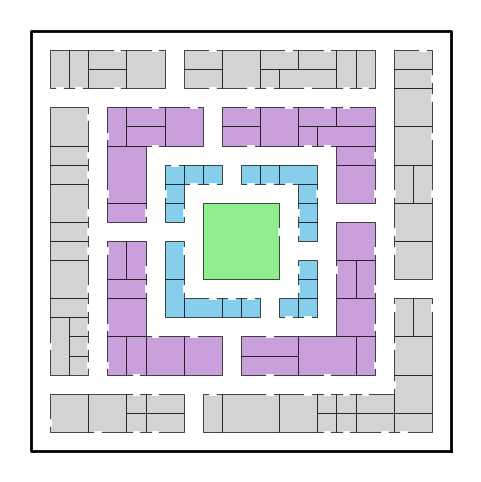

<Figure size 640x480 with 0 Axes>

In [22]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()
plt.savefig('gc_empty.png')

Each Building is assigned a unique identifier by its type and door coordinate. For example, the retail building with door coordinate (12, 3) has the id 'r-x12-y3'. Individual Buildings objects and their attributes may be accessed throught the city.buildings dictionary.

In [23]:
print(city.buildings['r-x12-y3'].blocks)
city.buildings['r-x12-y3'].door_centroid

[(10, 1), (10, 2), (11, 1), (11, 2), (12, 1), (12, 2)]


(12.5, 3.0)

Once a City object has been defined, a Population object can be initialized. The Population object will contain the Agents of the city and generate their trajectories.

## Agents and trajectories

Agents are tied to a specific City instance, and are represented by the Agent class, which contains a work and home location, as well as a 'mobility diary' that is used to generate granular trajectories. When instantiating an agent, their mobility diary can be initialized in two ways:
1. With a user-provided destination diary.
2. Without a diary and then a diary is generated with the EPR model.

These destination diaries are later replaced by a realized mobility diary that takes into account the travel time between buildings and, thus, should be regarded as a mobility plan. 

### User-provided diary initialization

Initializing in this way simply requires passing a DataFrame object with appropriate diary columns to the Agent constructor. 

In [24]:
# Instantiate population to collect all agents
population = Population(city)

In [25]:
# Initialization with custom diary
start_time = [datetime(2000, 1, 1, hour=0, minute=0) + timedelta(minutes=15*t) for t in range(22)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [15]*22  # in minutes
location = ['h-x8-y13'] * 2 + ['r-x12-y3'] * 4 + ['w-x15-y15'] * 12 + ['h-x8-y13'] * 4

d_diary = pd.DataFrame({"unix_timestamp":unix_timestamp,
                            "local_timestamp":start_time,
                            "duration":duration,
                            "location":location})

d_diary = tg.condense_destinations(d_diary)

Alice = Agent(identifier="Alice",
              home='h-x8-y13',
              workplace='w-x15-y15',
              city=city,
              destination_diary=d_diary)

population.add_agent(Alice)
population.generate_trajectory(agent=Alice, seed=100)

print(Alice.diary.head())

   unix_timestamp     local_timestamp  duration   location
0       946684800 2000-01-01 00:00:00        31   h-x8-y13
1       946686660 2000-01-01 00:31:00         6       None
2       946687020 2000-01-01 00:37:00        54   r-x12-y3
3       946690260 2000-01-01 01:31:00         7       None
4       946690680 2000-01-01 01:38:00       173  w-x15-y15


The helper function `condense_destinations` simply combines consecutive stops to the same destination. After generating a trajectory with `generate_trajectory` we can see that there are entries with a value of None in the diary, while the destination diary provided was 'complete', this is because the destination diary specifies the building the agent has _planned_ to visit at a given time, but the diary has the information of where the agent's _realized_ location, taking into consideration the travel time between buildings. 

In [26]:
Alice.__dict__

{'identifier': 'Alice',
 'home': 'h-x8-y13',
 'workplace': 'w-x15-y15',
 'city': <city_gen.City at 0x11174ec40>,
 'destination_diary': Empty DataFrame
 Columns: [unix_timestamp, local_timestamp, duration, location]
 Index: [],
 'diary':    unix_timestamp     local_timestamp  duration   location
 0       946684800 2000-01-01 00:00:00        31   h-x8-y13
 1       946686660 2000-01-01 00:31:00         6       None
 2       946687020 2000-01-01 00:37:00        54   r-x12-y3
 3       946690260 2000-01-01 01:31:00         7       None
 4       946690680 2000-01-01 01:38:00       173  w-x15-y15
 5       946701060 2000-01-01 04:31:00         4       None
 6       946701300 2000-01-01 04:35:00        56   h-x8-y13,
 'still_probs': {'park': 0.5, 'home': 0.9, 'work': 0.9, 'retail': 0.5},
 'speeds': {'park': 1.0204081632653061,
  'home': 0.3826530612244898,
  'work': 0.3826530612244898,
  'retail': 0.8928571428571429},
 'dt': 1,
 'trajectory':             x          y     local_timestamp  unix_ti

### Diary generation with EPR model

If no diary is provided, agents are initialized with an empty diary. When calling `Population.generate_trajectory`, the destination diary is generated and then a granular trajectory is sampled from it. Unlike the case with a user-provided diary, this option requires specifying the duration of the trajectory, with a parameter `T` specifying the ending datetime, while the start_time is provided when creating the Agent. 

The following agent, Bob, is given home `h-x8-y8` and workplace `w-x18-y4`. We generate a trajectory for Bob that lasts a week from midnight January 1, 2024 to midnight Janurary 8, 2024.

In [27]:
# Initialization and diary generation
Bob = Agent(identifier="Bob",
            home='h-x8-y8',
            workplace='w-x18-y4',
            city=city,
            start_time=datetime(2024, 1, 1, hour=0, minute=0))

population.add_agent(Bob)
population.generate_trajectory(Bob, 
                               T=datetime(2024, 1, 8, hour=0, minute=0))

print(Bob.diary.head())

   unix_timestamp     local_timestamp  duration   location
0      1704085200 2024-01-01 00:00:00       481    h-x8-y8
1      1704114060 2024-01-01 13:01:00         4       None
2      1704114300 2024-01-01 13:05:00        56  p-x13-y11
3      1704117660 2024-01-01 14:01:00         3       None
4      1704117840 2024-01-01 14:04:00       177   w-x15-y9


In [28]:
Bob.trajectory.head()

,x,y,local_timestamp,unix_timestamp,identifier
0,7.5,8.0,2024-01-01 00:00:00,1704085200,Bob
1,7.5,8.0,2024-01-01 05:01:00,1704085260,Bob
2,7.5,8.0,2024-01-01 05:02:00,1704085320,Bob
3,7.5,8.0,2024-01-01 05:03:00,1704085380,Bob
4,7.5,8.0,2024-01-01 05:04:00,1704085440,Bob


In [29]:
traj = Bob.diary

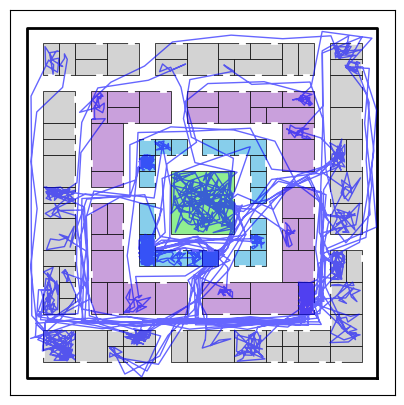

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.plot(Bob.trajectory.x, Bob.trajectory.y, linewidth=1, color='blue', alpha=0.6)

plt.savefig("garden-city-one-user.png")

The following code produces an animation of Bob's movement. We limit the animation to the 24 hours between midnight January 4 to midnight January 5 for speed and tractability of the output.

In [31]:
# fig, ax = plt.subplots(figsize=(6, 6))

# city.plot_city(ax, doors=True, address=False, zorder=1)

# ax.set_yticklabels([])
# ax.set_xticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# line, = ax.plot([], [], color='blue', alpha=0.1)
# scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
# time_text = ax.text(0.5, 0.975, '', transform=ax.transAxes)

# fade_length = 60  # Adjust this to control the length of the fade

# df = Bob.trajectory[5760:7200]  # 0:00 Jan 4 – 0:00 Jan 5

# def update(i):
#     if i < fade_length:
#         current_fade_length = i + 1
#     else:
#         current_fade_length = fade_length
#     alphas = np.array([np.exp(-0.5*x) for x in range(current_fade_length)][::-1])

#     line.set_data(df['x'].iloc[:i], df['y'].iloc[:i])
#     scatter.set_offsets(df[['x', 'y']].iloc[:i])
#     scatter.set_alpha(np.pad(alphas, (i + 1 - current_fade_length, 0), 'constant'))
#     time_text.set_text(df['local_timestamp'].iloc[i].strftime('%Y-%m-%d %H:%M:%S'))
#     time_text.set_position((0.38, 0.965))
#     time_text.set_fontsize(8)
#     return line, scatter


# anim = FuncAnimation(fig, update, frames=len(df), interval=50, blit=True)
# anim.save('anim-epr.gif', writer=PillowWriter(fps=20))
# plt.close(fig)

## Sparsifying a complete trajectory

From a complete, ground-truth trajectory (see previous section), a sparsifed trajectory can be sampled via a hierarchical non-homogeneous Poisson process. This sampler seeks to recreate realistic sparsity patterns that are both incomplete and "bursty"—replicating the observation that there are often long periods of inactivity interspersed with short periods with frequent pings.

The sampling function `Agent.sample_traj_hier_nhpp` is controlled by three parameters: 
* `beta_start`: the start times of bursts occur according to a Poisson Process with rate 1/`beta_start`
* `beta_dur`: the duration of bursts are sampled from a Exponential distribution with rate 1/`beta_dur`
* `beta_ping`: within a burst, pings are sampled according to a Poisson Process with rate 1/`beta_ping`

These parameters can be interpreted as follows: A burst is expected every `beta_start` minutes and lasts an expected `beta_dur` minutes. Within the burst, a ping is expected to be sampled every `beta_ping` minutes.

In the example below, we sample from Bob's complete trajectory with the following parameters: `beta_start`=300, `beta_dur`=60, and `beta_ping`=10.

In [128]:
hier_nhpp_params = (300, 60, 10)
seed = 2
burst_info = Bob.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed, output_bursts=True)
#print(Bob.sparse_traj)

The following code produces a chart that visualizes the distribution of the sparsified pings.

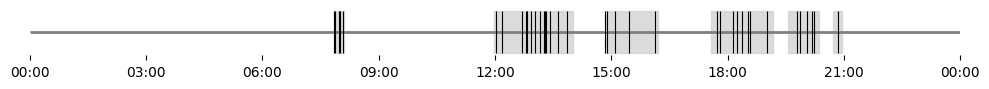

In [140]:
fig, ax = plt.subplots(figsize=(10, 1))

ax.hlines(1, pd.Timestamp('2024-01-01 00:00'), pd.Timestamp('2024-01-02 00:00'), color='gray', linewidth=2)

#ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

for i, row in burst_info.iterrows():
    ax.fill_betweenx(
        [0.95, 1.05],
        row['start_time'],
        row['end_time'],
        color='lightgrey',
        alpha=0.8,
        zorder=1
    )

ax.vlines(Bob.sparse_traj['local_timestamp'], 0.95, 1.05, color='black', linewidth=0.8, alpha=1)

ax.set_xlim(pd.Timestamp('2024-01-01 00:00'), pd.Timestamp('2024-01-02 00:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=0)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_visible(False)

plt.tight_layout()
fig.savefig("nhpp-sampling.png")

plt.show()

# Generating multiple agents

A population may contain any number of agents, which can be initialized en masse using the `Population.generate_agents` method. Each agent is assigned a randomly name as well as a uniformly sampled home and workplace. The `start_time` parameter indicates the time at which the agents start their trajectories.

Agent trajectories can be generated by looping over each agent and running the `Population.generate_trajectory` function as explained above. Note: if using a seed, make sure that each agent's seed is different to avoid all agents having the same trajectory.

In [ ]:
population2 = Population(city)
population2.generate_agents(N = 5,
                            start_time = datetime(2024, 1, 1, hour=8, minute=0),
                            seed=100)

for i, agent_id in enumerate(population2.roster):
    agent = population2.roster[agent_id]
    population.generate_trajectory(agent, 
                                   T=datetime(2024, 1, 8, hour=0, minute=0),
                                   seed=100+i)
    agent.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed+i)
    
population2.roster

Any individual agent can be accessed by calling their id through the `Population.roster` dictionary. 

In [ ]:
nifty_saha = population2.roster['nifty_saha']
print(nifty_saha.diary)
print(nifty_saha.trajectory)
print(nifty_saha.sparse_traj)

# Demonstration: Clustering Algorithms

To demonstrate one use case of our model, we explore how differing degrees of sparsity can affect the performance of stop detection algorithms like DBSCAN. We first initialize an agent (Charlie) and generate a complete trajectory. In what proceeds, we manually initialize Charlie's destination diary as consecutive 1-hour visits to two homes followed by a 3-hour visit at a larger retail building. A more extended simulation can (and should) leverage the exploration and preferential return generation model. For this toy example, however, we present an artificial example for simplicity.

In [150]:
start_time = [datetime(2024, 6, 1, hour=0, minute=0) + timedelta(minutes=60*t) for t in range(5)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*5  # in minutes

location = ['h-x13-y11'] * 1 + ['h-x13-y8'] * 1 + ['r-x18-y10'] * 3

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = tg.condense_destinations(destination)

Charlie = Agent("Charlie",
                'h-x13-y11',
                'w-x15-y9',
                city,
                destination_diary=destination,
                dt=1)

population.add_agent(Charlie)
population.generate_trajectory(Charlie, seed=75)

Charlie.diary

Agent identifier already exists in population. Replacing corresponding agent.


,unix_timestamp,local_timestamp,duration,location
0,1717200000,2024-06-01 00:00:00,61,h-x13-y11
1,1717203660,2024-06-01 01:01:00,2,None
2,1717203780,2024-06-01 01:03:00,58,h-x13-y8
3,1717207260,2024-06-01 02:01:00,4,None
4,1717207500,2024-06-01 02:05:00,176,r-x18-y10


Charlie's ground-truth trajectory is plotted below.

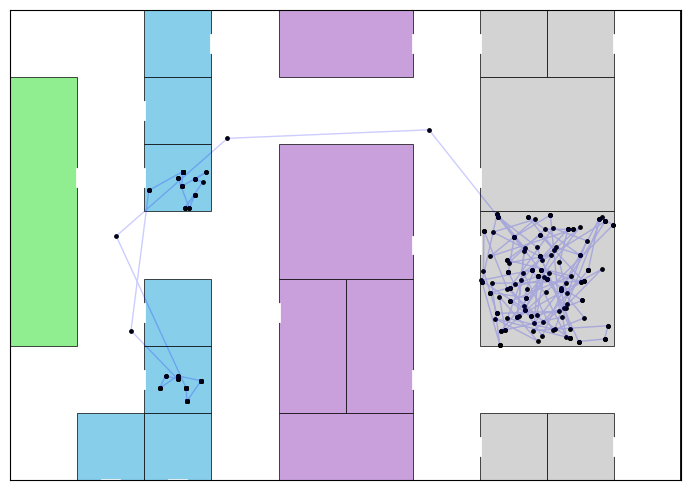

<Figure size 640x480 with 0 Axes>

In [151]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(Charlie.trajectory.x, Charlie.trajectory.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.plot(Charlie.trajectory.x, Charlie.trajectory.y, linewidth=1, color='blue', alpha=0.2)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

plt.savefig("exp-trajectory.png")

We sample Charlie's ground-truth trajectory at two levels of sparsity. 
* The higher sparsity sample uses parameters `beta_start`=120, `beta_dur`=30, and `beta_ping`=5. 
* The lower sparsity sample uses parameters `beta_start`=60, `beta_dur`=45, and `beta_ping`=2. 

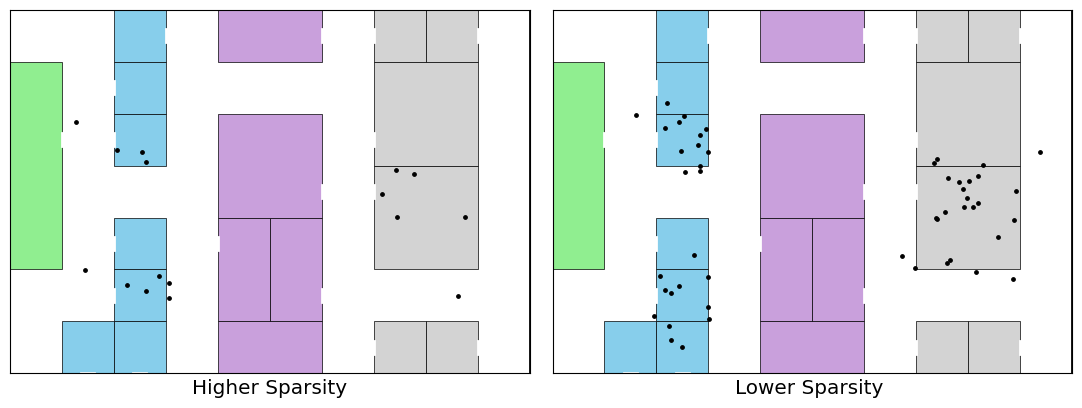

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
hier_nhpp_params = [(120, 30, 5), (60, 45, 2)]
seed = 170 #375

for j in range(2):
    ax = axes[j]
    Charlie.sample_traj_hier_nhpp(*hier_nhpp_params[j], seed=seed)

    ax.scatter(Charlie.sparse_traj.x, Charlie.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.set_xlim(12, 22)
    ax.set_ylim(7, 14)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_xlabel('Higher Sparsity', fontsize='x-large')
axes[1].set_xlabel('Lower Sparsity ', fontsize='x-large')

plt.tight_layout()
#plt.savefig("exp-sparse.png")
plt.show()

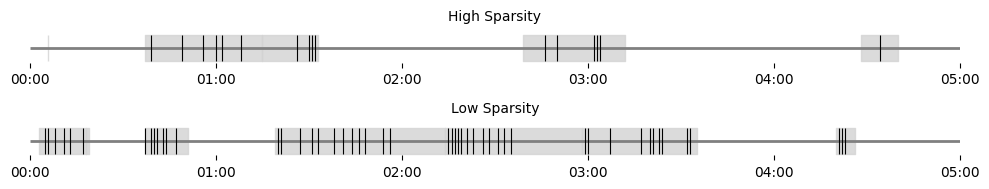

In [189]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2))

for j in range(2):
    ax = axes[j]
    burst_info = Charlie.sample_traj_hier_nhpp(*hier_nhpp_params[j], seed=seed, output_bursts=True)

    ax.hlines(1, pd.Timestamp('2024-06-01 00:00'), pd.Timestamp('2024-06-01 05:00'), color='gray', linewidth=2)

    #ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

    for i, row in burst_info.iterrows():
        ax.fill_betweenx(
            [0.95, 1.05],
            row['start_time'],
            row['end_time'],
            color='lightgrey',
            alpha=0.8,
            zorder=1
        )

    ax.vlines(Charlie.sparse_traj['local_timestamp'], 0.95, 1.05, color='black', linewidth=0.8, alpha=1)

    ax.set_xlim(pd.Timestamp('2024-06-01 00:00'), pd.Timestamp('2024-06-01 05:00'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=0)

    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.yaxis.set_visible(False)

    ax.set_title(f"{['High', 'Low'][j]} Sparsity", fontsize=10, pad=10)

plt.tight_layout()
fig.savefig("exp-sparsity-levels.png")

plt.show()

We are interested in how the sparsity of the trajectory and parameterization of stop detection algorithms interact. Here, we use a temporal version of DBSCAN to cluster pings into stops. DBSCAN takes three parameters: `time_thresh`, `dist_thresh`, and `min_pts`. Roughly, a point is considered part of a dense cluster if it has at least `min_pts` neighboring points within a distance `dist_thresh` and time gap `time_thresh`; otherwise, it is labeled as noise. 

We explore a fine and a coarse parameterization of DBSCAN and apply each to the higher and lower sparsity trajectories.

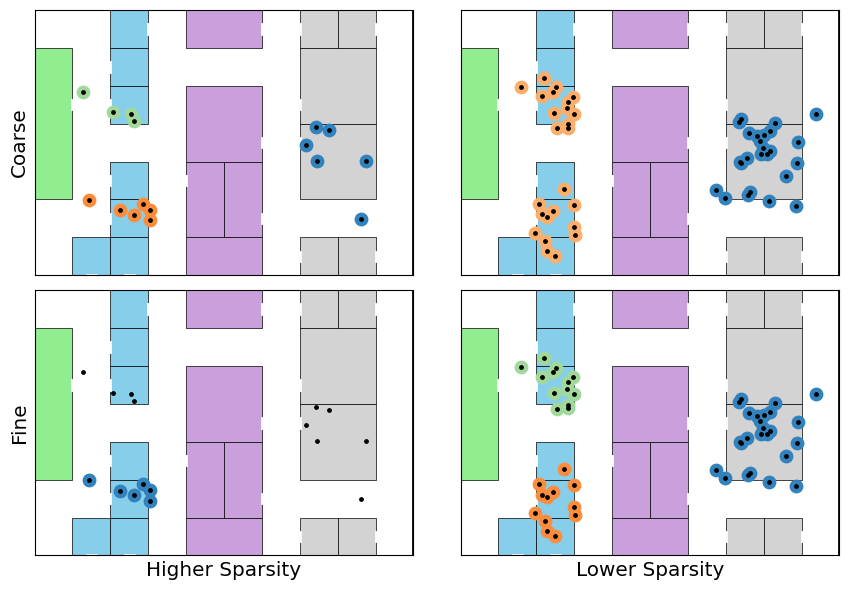

In [192]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
dbscan_params = [(120, 2, 2), (60, 1, 4)]

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        Charlie.sample_traj_hier_nhpp(*hier_nhpp_params[j], seed=seed)

        dbscan_out = sd.temporal_dbscan(Charlie.sparse_traj, *dbscan_params[i])

        num_clusters = sum(dbscan_out.cluster.unique() > -1)
        for cid in range(num_clusters):
            cpings = dbscan_out[dbscan_out.cluster == cid]
            cdata = Charlie.sparse_traj.loc[cpings.index]
            col = cm.tab20c(cid/(num_clusters+1))
            ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

        ax.scatter(Charlie.sparse_traj.x, Charlie.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
        city.plot_city(ax, doors=True, address=False, zorder=1)

        ax.set_xlim(12, 22)
        ax.set_ylim(7, 14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('Coarse', fontsize='x-large')
axes[1, 0].set_ylabel('Fine', fontsize='x-large')
axes[1, 0].set_xlabel('Higher Sparsity', fontsize='x-large')
axes[1, 1].set_xlabel('Lower Sparsity', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp-stdbscan.png")
plt.show()